In [1]:
import re
import json
from joblib import load

import pandas as pd
import numpy as np
import catboost as cb
import fasttext
from tqdm import tqdm
from sklearn.metrics import accuracy_score, roc_auc_score

In [5]:
def _create_features(df, svd):
    df["descr_len"] = df.description.apply(lambda x: len(x))
    df["descr_count_7"] = df.description.apply(lambda x: x.count("7"))
    df["descr_count_+7"] = df.description.apply(lambda x: x.count("+7"))
    df["title_len"] = df.title.apply(lambda x: len(x))
    df["title_count_numb"] = df.title.apply(lambda x: len(re.findall(r"\d", x)))
    df["descr_count_numb"] = df.description.apply(lambda x: len(re.findall(r"\d", x)))
    embeddings = list(list(x) for x in df["text_embeddings"].values)
    df_descr_svd = pd.DataFrame(svd.transform(embeddings), index=df.index)
    return pd.concat([df, df_descr_svd], axis=1)

def _load_svd_model(path_to_model):
    return load(path_to_model)

def _get_data(path_to_data, ft_model):
    df = pd.read_csv(path_to_data)
    df.text = df.text.fillna("")
    df.price = df.price.fillna(df.price.mean())
    tqdm.pandas()
    df["text_embeddings"] = df.progress_apply(
        lambda x: vectorize_text(x["text"], ft_model), axis=1
    )
    df = df.dropna(subset=["text_embeddings"])
    return df


def _load_fasttext_model(path_to_model):
    ft_model = fasttext.load_model(path_to_model)

    return ft_model


def vectorize_text(text, ft_model):
    tokens = text.split()
    embeddings = []
    for token in tokens:
        vector = ft_model.get_word_vector(token)
        embeddings.append(vector)

    return np.mean(embeddings, axis=0)

def _check_quality(df, model):
    test_pool = cb.Pool(
        data=df[
            [
                c
                for c in df.columns
                if c
                not in ["description", "title", "datetime_submitted", "is_bad","text", "text_embeddings"]
            ]
        ],
        label=df["is_bad"],
        cat_features=["subcategory",
            "category",
            "region",
            "city"],
        # embedding_features=["text_embeddings"],
        # text_features=["text"]
    )
    df["predict"] = model.predict(test_pool)

    categories = dict(df.category.value_counts())

    roc = []
    for category in categories:
        tmp = df[df.category == category]
        predicted_y = tmp.predict
        true_y = tmp.is_bad
        score = roc_auc_score(true_y, predicted_y)
        roc.append(score)
        print(f"{category}: {score}")
    print("-----------------------------------------------")
    print("mean", sum(roc) / len(roc))


In [3]:
path_to_val_data = "/home/kenny/avito_tech/data/processed_nltk/val_data.csv"
path_fasttext_model = "/home/kenny/avito_tech/models/fasttext/skipgram_nltk_100.bin"
path_to_svd_model = "/home/kenny/avito_tech/models/catboost/svd_model_100.bin"

In [6]:
ft_model = _load_fasttext_model(path_fasttext_model)
svd_model = _load_svd_model(path_to_svd_model)
val_df = _get_data(path_to_val_data, ft_model)
val_df = _create_features(val_df, svd_model)

loaded_model = cb.CatBoostClassifier()
# loaded_model.load_model('/home/kenny/avito_tech/models/catboost/model_without_embeddings.bin')
# loaded_model.load_model('/home/kenny/avito_tech/models/catboost/model_without_embeddings_1.bin')
# loaded_model.load_model('/home/kenny/avito_tech/models/catboost/model_with_svd_full_100.bin')
loaded_model.load_model('/home/kenny/avito_tech/models/catboost/model_pred.bin')

_check_quality(val_df, loaded_model)

100%|██████████| 15374/15374 [00:08<00:00, 1718.13it/s]
/tmp/ipykernel_1938035/2064446275.py:16: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  for i in df.description.str.contains(regex_mobile).fillna(False)
/tmp/ipykernel_1938035/2064446275.py:21: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  for i in df.description.str.contains(regex_phone).fillna(False)
/tmp/ipykernel_1938035/2064446275.py:25: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  for i in df.description.str.contains(regex_email).fillna(False)
/tmp/ipykernel_1938035/2064446275.py:29: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  for i in df.description.str.contains(regex_mess

Транспорт: 0.9318768771191112
Бытовая электроника: 0.7326632165605095
Для дома и дачи: 0.8567283482219846
Недвижимость: 0.8917773573374423
Личные вещи: 0.7280406516543513
Хобби и отдых: 0.8588888888888889
Услуги: 0.8111903037201842
Работа: 0.8393415778668492
Для бизнеса: 0.7744786143513609
Животные: 0.8788671023965142
-----------------------------------------------
mean 0.8303852938117195


In [30]:
val_df[val_df.category == "Личные вещи"].is_bad.value_counts()

is_bad
0    1546
1     177
Name: count, dtype: int64

[]

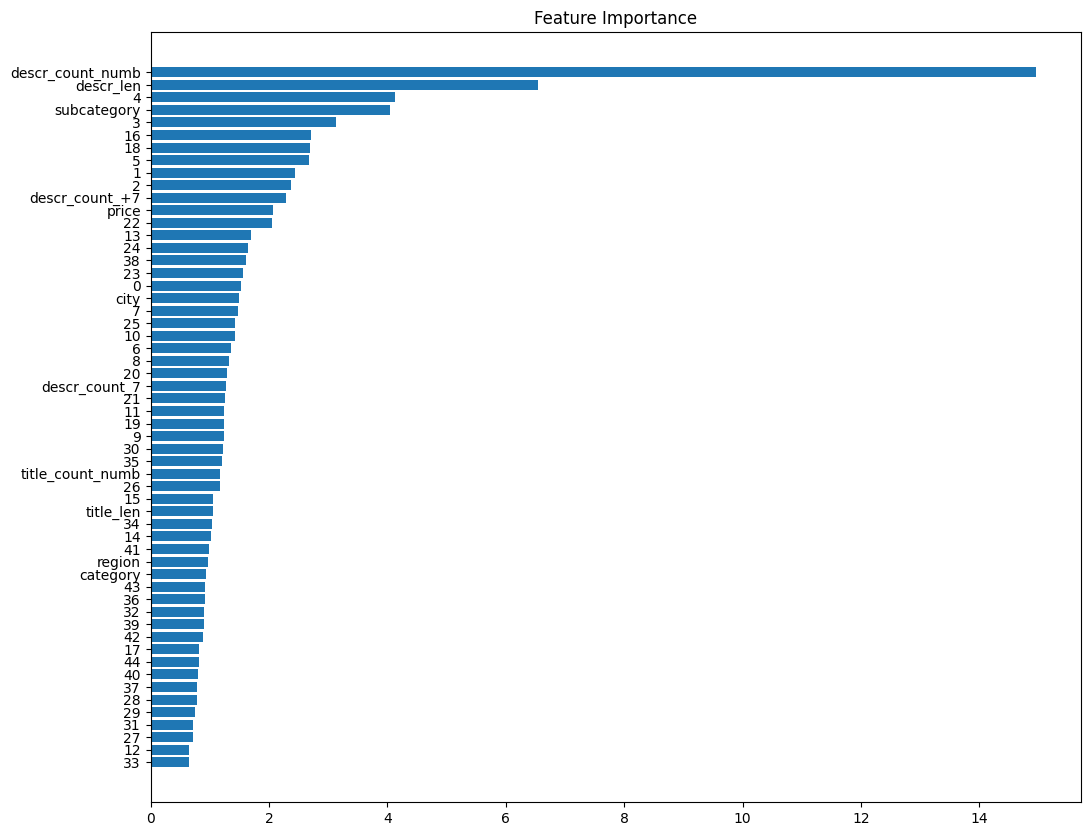

In [13]:
import matplotlib.pyplot as plt
feature_importance = loaded_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 10))
temp = val_df.drop(["description", "title", "datetime_submitted", "is_bad", "text", "text_embeddings"], axis=1)
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(temp.columns)[sorted_idx])
plt.title('Feature Importance')
plt.plot()

In [ ]:
with open("model_1_params.json", "w") as file:
    json.dump(loaded_model.get_all_params(), file)

In [2]:
pred_model = cb.CatBoostClassifier()
pred_model.load_model('/home/kenny/avito_tech/models/catboost/pred_model')

In [3]:
pred_model.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'AUC',
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'],
 'iterations': 2000,
 'sampling_frequency': 'PerTree',
 'fold_permutation_block': 0,
 'leaf_estimation_method': 'Newton',
 'od_pval': 0,
 'counter_calc_method': 'SkipTest',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'ctr_leaf_count_limit': 18446744073709551615,
 'bayesian_matrix_reg': 0.1000000015,
 'one_hot_max_size': 2,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'od_type': 'Iter',
 'rsm': 1,
 'boost_from_average': False,
 'max_ctr_complexity': 4,
 'model_size_reg': 0.5,
 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=

In [5]:
with open("pred_model_params.json", "w") as file:
    json.dump(pred_model.get_all_params(), file)

In [13]:
def _check_quality_2(df, model):
    # test_pool = cb.Pool(
    #     data=df[
    #         [
    #             c
    #             for c in df.columns
    #             if c
    #             not in ["description", "title", "datetime_submitted", "is_bad"]
    #         ]
    #     ],
    #     label=df["is_bad"],
    #     cat_features=["subcategory", "category", "region", "city"],
    #     # embedding_features=["text_embeddings"],
    #     text_features=["text"]
    # )
    # df["predict"] = model.predict(test_pool)
    df = df.rename({'text': 'text_stem'}, axis=1)
    df["predict"] = model.predict(df[['title', 'subcategory', 'category', 'region',
       'city', 'text_stem']])


    categories = dict(df.category.value_counts())

    roc = []
    for category in categories:
        tmp = df[df.category == category]
        predicted_y = tmp.predict
        true_y = tmp.is_bad
        score = roc_auc_score(true_y, predicted_y)
        roc.append(score)
        print(f"{category}: {score}")
    print("-----------------------------------------------")
    print("mean", sum(roc) / len(roc))

In [14]:
val_df = _get_data(path_to_val_data)
val_df = _create_features(val_df)
_check_quality_2(val_df, pred_model)

Транспорт: 0.775414041724812
Бытовая электроника: 0.5876530155254777
Для дома и дачи: 0.6814920842962094
Недвижимость: 0.6557159297041096
Личные вещи: 0.5928366259565417
Хобби и отдых: 0.6262962962962964
Услуги: 0.7036076473327469
Работа: 0.679538566819826
Для бизнеса: 0.7582184517497348
Животные: 0.6221496005809731
-----------------------------------------------
mean 0.6682922259986727


In [7]:
import pandas as pd

path = "/home/kenny/avito_tech/data/processed_nltk/train_data.csv"

In [8]:
val_df = pd.read_csv(path)

In [9]:
val_df[["title","description","text"]].head(4)

,title,description,text
0,Запчасти Мерседес Актрос (Mercedes Actros),"В разборе Mercedes-Benz Actros, 6008 год, Евро...",запчаст мерседес актрос mercedes actros разбор...
1,Шины,"Резина ""КАМА-ЕВРО"", R-42, состояние нормальное...",шин резин кам евр r 42 состоян нормальн звон н...
2,SAMSUNG Galaxy S10,Samsung Galaxy S40/\n/\nВам салютует сеть мага...,samsung galaxy s10 samsung galaxy s40 салют се...
3,SAMSUNG Galaxy S8,Samsung Galaxy S8/\n/\nВас приветствует сеть м...,samsung galaxy s8 samsung galaxy s8 приветств ...


### Исследуем лучшую модель, и попробуем провести feature selection хороший


Лучшая модель на данный момент из эксперимента №1 

In [4]:
import pandas as pd
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split

# model_path = "/home/kenny/avito_tech/models/catboost/catboost_classifier_exp_1.cbm"
# train_data_path = "/home/kenny/avito_tech/data/processed/train_data.csv"
test_data_path = "/Users/arsenchik/Desktop/avito_tech/data/processed/val_data.csv"

load model

In [2]:
model_path = "/Users/arsenchik/Desktop/avito_tech/models/catboost_base_classifier.cbm"
cb_model = CatBoostClassifier()
cb_model.load_model(model_path)

load data

In [5]:
# df_train = pd.read_csv(train_data_path)
df_test = pd.read_csv(test_data_path)

In [6]:
df_test = df_test[cb_model.feature_names_]
predictions = cb_model.predict_proba(df_test)[:, 1]

In [8]:
indices = range(len(predictions))
predictions = pd.DataFrame(
    {"index": range(len(predictions)), "prediction": predictions}
)

In [11]:
task_1_path = "/Users/arsenchik/Desktop/avito_tech/data/catboost_task1_prediction.csv"

task_1_df = pd.read_csv(task_1_path)

In [19]:
task_1_df.head(5)

,index,prediction
0,0,0.991217
1,1,0.008705
2,2,0.120166
3,3,0.858807
4,4,0.054275


In [20]:
predictions.head(5)

,index,prediction
0,0,0.991217
1,1,0.008705
2,2,0.120166
3,3,0.858807
4,4,0.054275


In [4]:
df_train.drop(['description', 'title', 'datetime_submitted'], axis=1, inplace=True)
df_test.drop(['description', 'title',  'datetime_submitted'], axis=1, inplace=True)

In [5]:
df_train, df_val = train_test_split(df_train, test_size=0.1, random_state=43, stratify=df_train['category'])

In [6]:
cat_features = ['subcategory', 'category', 'region', 'city']

train_pool = Pool(data=df_train.drop(['is_bad'], axis=1), cat_features=cat_features, label=df_train['is_bad'], text_features=['filtered_text', 'text', 'filtered_numbers'])
val_pool = Pool(data=df_val.drop(['is_bad'], axis=1), cat_features=cat_features, label=df_val['is_bad'], text_features=['filtered_text', 'text', 'filtered_numbers'])

In [7]:
cb_model.get_feature_importance(val_pool, prettified=True)

,Feature Id,Importances
0,text,46.089186
1,filtered_text,10.836068
2,phone_normal,7.739035
3,filtered_numbers,5.933859
4,description_count_numbers,5.435821
5,phone_strange,4.244640
6,home_phone,4.091040
7,subcategory,3.375789
8,description_len,3.294443
9,category,1.720229


Text(0.5, 1.0, 'Permutation Importance')

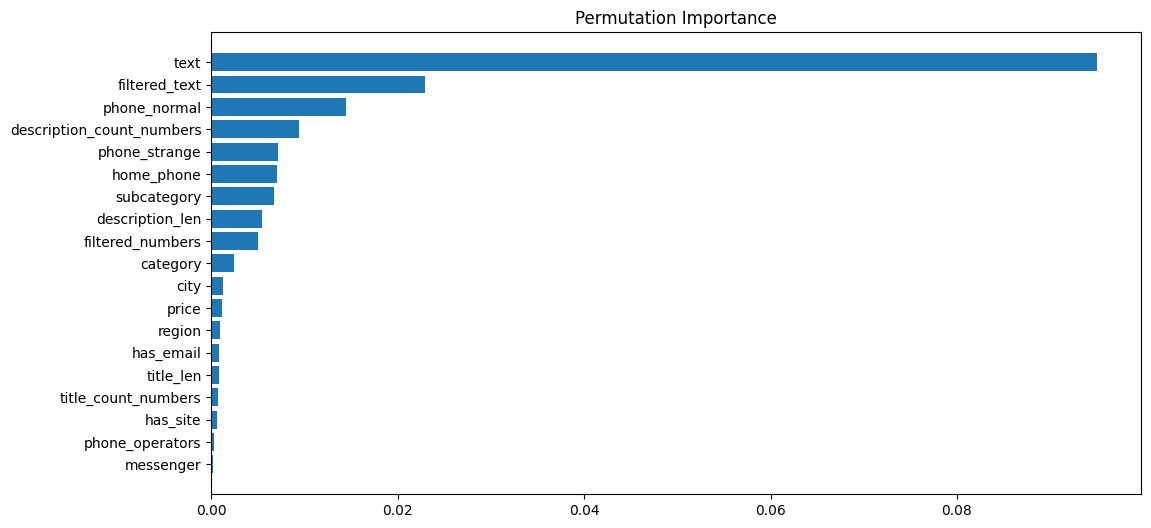

In [9]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np
X_test = df_val.drop("is_bad", axis=1)
y_test = df_val["is_bad"]
perm_importance = permutation_importance(cb_model, X_test, y_test, n_repeats=10, random_state=1066)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Permutation Importance')